In [24]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt

In [25]:
IMAGE_SIZE = 256
BATCH_SIZE = 32
CHANNELS = 3
EPOCHS = 50

In [26]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "PlantVillage",
    shuffle=True,
    image_size = (IMAGE_SIZE, IMAGE_SIZE),
    batch_size = BATCH_SIZE
)

Found 2152 files belonging to 4 classes.


In [27]:
class_names = dataset.class_names
class_names 

['.ipynb_checkpoints',
 'Potato___Early_blight',
 'Potato___Late_blight',
 'Potato___healthy']

In [28]:
len(dataset)

68

This is because the total size has been distrubuted in 32 batch size of total 68 * 32 = 2176 i.e. 68 packets

In [29]:
for image_batch, label_batch in dataset.take(1):
    print(image_batch.shape)
    print(label_batch.numpy())

(32, 256, 256, 3)
[2 2 2 1 2 2 1 2 2 1 1 2 3 2 2 2 2 1 1 2 1 2 1 2 1 2 1 1 2 2 2 2]


3 here denotes RGB channel
The later list gives the classification of all image

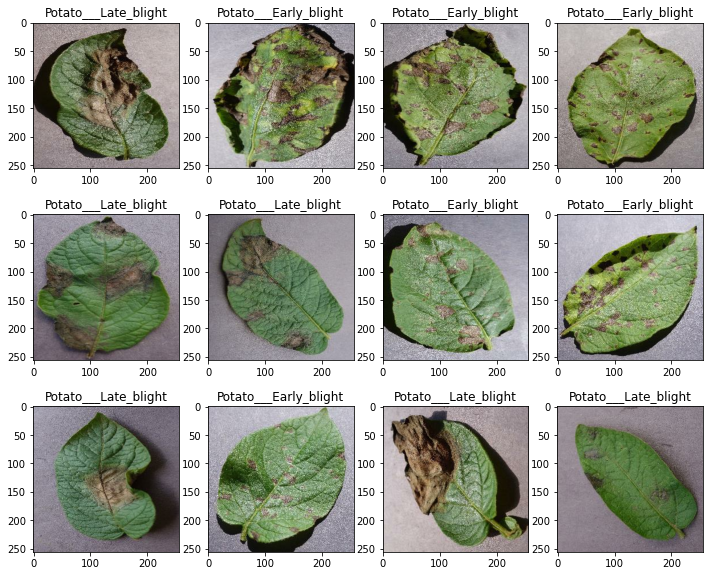

In [30]:
plt.figure(figsize=(12,10))
for image_batch, label_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3,4,i+1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[label_batch[i]])

In [31]:
train_size = 0.8
len(dataset)*train_size

54.400000000000006

Here we dont have function like sklearn's train_test_split. Hence here on the basis of percentage like 80% of the total batch size i.e. 54% will be our data for training

In [32]:
train_ds = dataset.take(54)
len(train_ds)

54

In [33]:
test_ds = dataset.skip(54)
len(test_ds)

14

In [34]:
val_size = 0.1
len(dataset)*val_size 

6.800000000000001

In [35]:
val_ds = test_ds.take(6)
len(val_ds)

6

In [36]:
test_ds = test_ds.skip(6)
len(test_ds)

8

Instead of writing this code for dataset splitting we can write a function. H

In [37]:
def get_dataset_partition_tf(ds, train_split = 0.8, val_split = 0.1, test_split = 0.1,shuffle = True,  shuffle_size = 100000):
    ds_size = len(ds)
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed = 12)
    train_size = int(train_split*ds_size)
    val_size = int(val_split*ds_size)
    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    return train_ds, val_ds, test_ds

In [38]:
train_ds, val_ds, test_ds = get_dataset_partition_tf(dataset)

In [39]:
print(len(train_ds), len(val_ds), len(test_ds))

54 6 8


In [40]:
train_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)
val_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)

In [41]:
resize_and_rescale = tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
    layers.experimental.preprocessing.Rescaling(1.0/255)
])

In [42]:
data_augmentation = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(0.2),
])

for the last layer:
layer_dense(units = 3, activation = "softmax")
instead of this you can simply take units = 4
because [0,3) means excluding 3

In [43]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 4

model = models.Sequential([
    resize_and_rescale,
    data_augmentation, 
    layers.Conv2D(32, (3,3), activation = "relu", input_shape = input_shape),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, kernel_size = (3,3), activation = 'relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, kernel_size = (3,3), activation = 'relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,(3,3), activation = 'relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation = 'relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation = 'relu'),
    layers.MaxPooling2D((2,2)),
    layers.Flatten(),
    layers.Dense(64, activation = 'relu'),
    layers.Dense(n_classes, activation = 'softmax'),
])

model.build(input_shape= input_shape)

In [44]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_3 (Sequential)   (32, 256, 256, 3)         0         
                                                                 
 sequential_4 (Sequential)   (32, 256, 256, 3)         0         
                                                                 
 conv2d_6 (Conv2D)           (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d_6 (MaxPooling  (32, 127, 127, 32)       0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_7 (MaxPooling  (32, 62, 62, 64)         0         
 2D)                                                  

In [45]:
model.compile(
    optimizer = 'adam',
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics = ['accuracy']
)

In [61]:
with tf.device('/gpu:0'):
    history = model.fit(
    train_ds, 
    epochs = EPOCHS,
    batch_size = BATCH_SIZE, 
    verbose = 1,
    validation_data = val_ds
)

Epoch 1/50
54/54 [==============================] - 11s 168ms/step - loss: 0.0136 - accuracy: 0.9959 - val_loss: 0.0894 - val_accuracy: 0.9740
Epoch 2/50
54/54 [==============================] - 10s 170ms/step - loss: 0.0118 - accuracy: 0.9959 - val_loss: 0.1068 - val_accuracy: 0.9740
Epoch 3/50
54/54 [==============================] - 10s 169ms/step - loss: 0.0138 - accuracy: 0.9971 - val_loss: 0.0098 - val_accuracy: 0.9948
Epoch 4/50
54/54 [==============================] - 10s 169ms/step - loss: 0.0714 - accuracy: 0.9748 - val_loss: 0.1239 - val_accuracy: 0.9479
Epoch 5/50
54/54 [==============================] - 10s 164ms/step - loss: 0.0249 - accuracy: 0.9906 - val_loss: 0.0157 - val_accuracy: 0.9948
Epoch 6/50
54/54 [==============================] - 10s 166ms/step - loss: 0.0482 - accuracy: 0.9836 - val_loss: 0.0071 - val_accuracy: 1.0000
Epoch 7/50
54/54 [==============================] - 10s 165ms/step - loss: 0.0253 - accuracy: 0.9924 - val_loss: 0.0412 - val_accuracy: 0.9844

In [62]:
scores = model.evaluate(test_ds)

8/8 [==============================] - 2s 164ms/step - loss: 0.0059 - accuracy: 1.0000


In [63]:
scores

[0.005855978466570377, 1.0]

In [64]:
history

In [65]:
history.params

{'verbose': 1, 'epochs': 50, 'steps': 54}

In [66]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [67]:
history.history['accuracy']

[0.9958920478820801,
 0.9958920478820801,
 0.9971064925193787,
 0.9747652411460876,
 0.9906103014945984,
 0.9835680723190308,
 0.9923709034919739,
 0.9953051805496216,
 0.9832175970077515,
 0.9900234937667847,
 0.9964788556098938,
 0.9953051805496216,
 0.9953703880310059,
 0.9829812049865723,
 0.9953051805496216,
 0.9923709034919739,
 0.98591548204422,
 0.9947183132171631,
 0.9866898059844971,
 0.9947183132171631,
 0.9935445785522461,
 0.9941314458847046,
 0.9911971688270569,
 0.998826265335083,
 0.9855324029922485,
 0.9835680723190308,
 0.9941314458847046,
 0.9941314458847046,
 0.9953051805496216,
 0.9882628917694092,
 0.9958920478820801,
 0.9818075299263,
 0.9847418069839478,
 0.9982638955116272,
 0.9923709034919739,
 0.9994131326675415,
 0.9847418069839478,
 0.9894366264343262,
 0.9953051805496216,
 0.9976525902748108,
 0.9900234937667847,
 0.9976525902748108,
 0.9894366264343262,
 0.9965277910232544,
 0.9947183132171631,
 0.9785879850387573,
 0.9923709034919739,
 0.9958920478820801

Plotting accuracy of each epoch training on a graph

In [68]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

Text(0.5, 1.0, 'Training and Validation Accuracy')

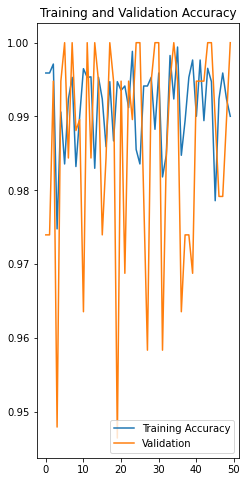

In [69]:
plt.figure(figsize=(8,8))
plt.subplot(1,2,1)
plt.plot(range(EPOCHS), acc, label = "Training Accuracy")
plt.plot(range(EPOCHS), val_acc, label = "Validation")
plt.legend(loc = 'lower right')
plt.title("Training and Validation Accuracy")

In [70]:
for images_batch, labels_batch in test_ds.take(1):
    print(images_batch[0].numpy().astype('uint8'))

[[[179 181 193]
  [181 183 195]
  [179 181 193]
  ...
  [160 157 168]
  [159 156 167]
  [149 146 157]]

 [[182 184 196]
  [185 187 199]
  [183 185 197]
  ...
  [146 143 154]
  [144 141 152]
  [139 136 147]]

 [[181 183 195]
  [184 186 198]
  [184 186 198]
  ...
  [145 142 153]
  [146 143 154]
  [150 147 158]]

 ...

 [[184 183 191]
  [183 182 190]
  [182 181 189]
  ...
  [133 128 135]
  [133 128 135]
  [134 129 136]]

 [[181 180 188]
  [182 181 189]
  [184 183 191]
  ...
  [132 127 134]
  [132 127 134]
  [131 126 133]]

 [[177 176 184]
  [180 179 187]
  [182 181 189]
  ...
  [130 125 132]
  [129 124 131]
  [129 124 131]]]


First image to predict
First image's actual label: Potato___Late_blight
Predicted label: Potato___Late_blight


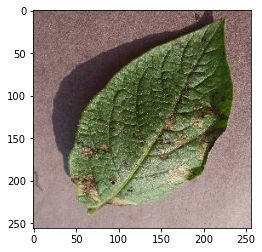

In [71]:
import numpy as np
for images_batch, labels_batch in test_ds.take(1):
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()
    
    print("First image to predict")
    plt.imshow(first_image)
    print("First image's actual label:", class_names[first_label])
    
    batch_prediction = model.predict(images_batch)
    print("Predicted label:", class_names[np.argmax(batch_prediction[0])])

In [72]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)
    
    predictions = model.predict(img_array)
    
    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100* (np.max(predictions[0])), 2)
    return predicted_class, confidence

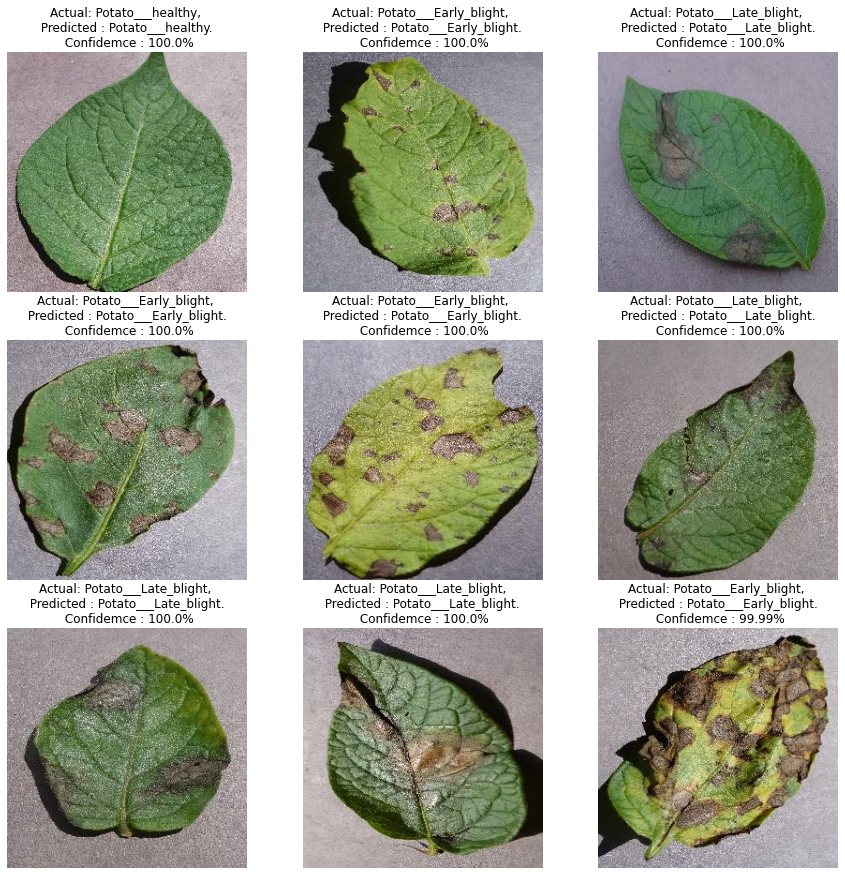

In [73]:
plt.figure(figsize = (15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3,3, i+1)
        plt.imshow(images[i].numpy().astype("uint8"))
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]]
        plt.title(f"Actual: {actual_class}, \n Predicted : {predicted_class}. \n Confidemce : {confidence}%")
        plt.axis("off")
        

In [74]:
import os 
model_version = max([int(i) for i in os.listdir("models") + [0]]) +1
model.save(f"models/{model_version}")                   

INFO:tensorflow:Assets written to: models/4\assets
